In [1]:
from scipy import *
import numpy as np
import WLanalysis
from matplotlib import pyplot

In [2]:
Ngrid = 50
Nk = '10k'
param_range = [[0,0.35],[0.28, 0.32],[1.9,2.3]]

In [3]:
Chi2_arr = load('likelihood/prob_{0}_N{1}.npy'.format(Nk, Ngrid)).T
Chi2_arr.shape

(3, 125000)

In [4]:
def plane_margin (chi2cube,Ngrid=Ngrid,x=23):
    prob = exp(-0.5*chi2cube).reshape(Ngrid, Ngrid, Ngrid)
    #prob /= sum(prob[~isnan(prob)])
    return [sum(prob,axis=i) for i in range(3)]
    #return prob[x],prob[:,x],prob[:,:,x]

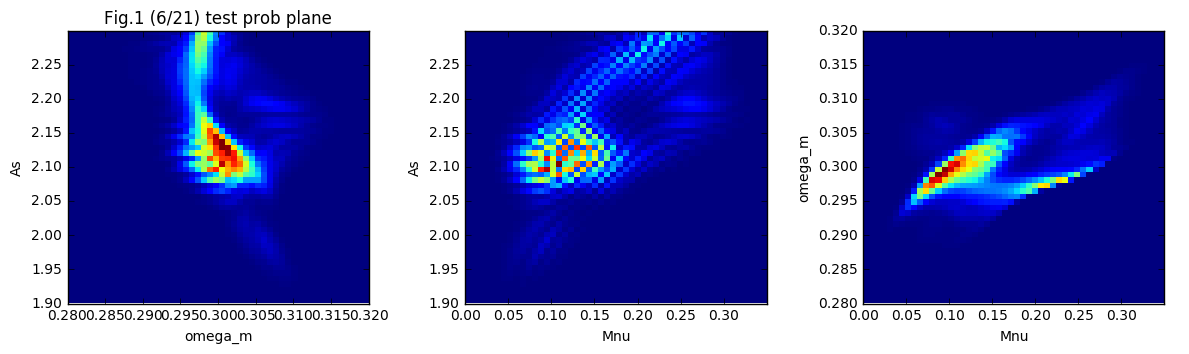

In [5]:
# for ix in range(50):
ix=23
f,axes=subplots(1,3,figsize=(12,3.5))
extents = ([param_range[1],param_range[2]],[param_range[0],param_range[2]],[param_range[0],param_range[1]])
labeles0 = ('Mnu','omega_m','As')
labels = ([labeles0[1],labeles0[2]],[labeles0[0],labeles0[2]],[labeles0[0],labeles0[1]])
i=0
for iP in plane_margin (Chi2_arr[0],x=ix):
    axes[i].imshow(iP.T,origin='lower',extent= array(extents[i]).flatten(),aspect='auto',interpolation='nearest')
    axes[i].set_xlabel(labels[i][0])
    axes[i].set_ylabel(labels[i][1])
    i+=1
plt.tight_layout()
axes[0].set_title('Fig.1 (6/21) test prob plane')
# savefig('likelihood/testpdf_%i.jpg'%(ix))
# close()
show()

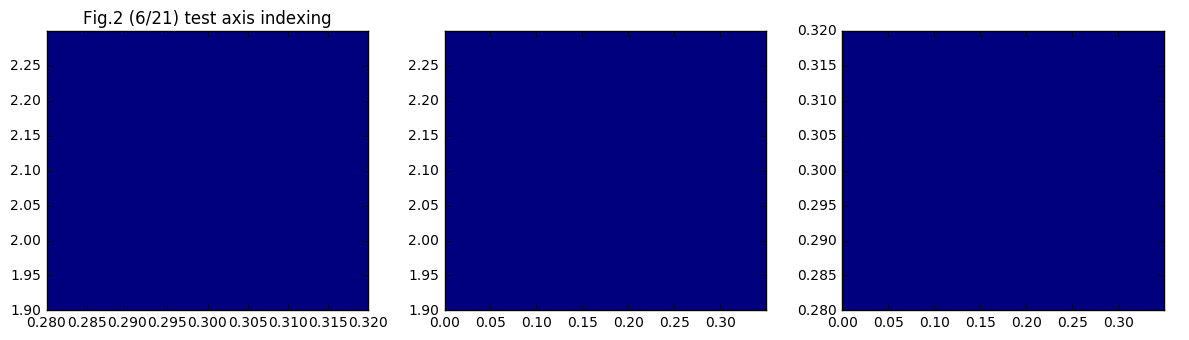

In [6]:
Ngrid =50 
param_range = [[0,0.35],[0.28, 0.32],[1.9,2.3]]
param_arr = [linspace(param_range[i][0],param_range[i][1],Ngrid) for i in range(3)]
param_list = array(meshgrid(param_arr[0],param_arr[1],param_arr[2],indexing='ij')).reshape(3,-1).T

f,axes=subplots(1,3,figsize=(12,3.5))
i=0
for iP in param_list.T:
    x=mean(iP.reshape(Ngrid, Ngrid, Ngrid),axis=i)
    axes[i].imshow(x,origin='lower',extent= array(extents[i]).flatten(),aspect='auto')
    i+=1
axes[0].set_title('Fig.2 (6/21) test axis indexing')
plt.tight_layout()
show()

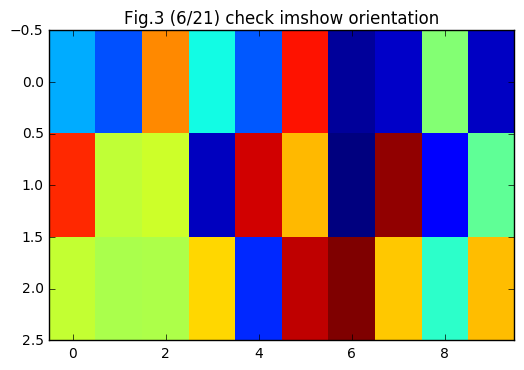

In [7]:
imshow(rand(3,10),aspect='auto',interpolation='nearest')
title('Fig.3 (6/21) check imshow orientation')
show()

In [8]:
############ test GP #########
from scipy import *
import numpy as np
import WLanalysis
from emcee.utils import MPIPool 
import sys, itertools

Nk='10k' # '5ka', '5kb'
Ngrid = 50

z_arr = arange(0.5,3,0.5)
Nz = len(z_arr)
#####################################
######## set up folders #############
#####################################

######## stampede2
stats_dir = '/scratch/02977/jialiu/peakaboo/'
ebcov_dir = stats_dir+'stats/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995/1024b512/box5/output_eb_5000_s4/seed0/'

    
######### local
stats_dir = '/Users/jia/Dropbox/weaklensing/PDF/'
ebcov_dir = stats_dir+'box5/output_eb_5000_s4/seed0/'

eb_dir = stats_dir+'stats_avg/output_eb_5000_s4/'
eb1k_dir = stats_dir+'stats_avg_1k/output_eb_5000_s4/'

#####################################
##### initiate avg statistics #######
#####################################

###### PS shape:(5, 101, 20)
psI = array( [load(eb_dir+'ALL_igalXigal_z{0}_z{0}_{1}.npy'.format(iz,Nk)) for iz in z_arr])
psI1ks = array( [[load(eb1k_dir+'ALL_igalXigal_z{0}_z{0}_1k{1}.npy'.format(iz,ik)) for iz in z_arr] 
                 for ik in range(10)])
#psN = array( [load(eb_dir+'ALL_galXgal_z{0}_z{0}_{1}.npy'.format(iz,Nk)) for iz in z_arr])

##### 1d PDF shape:(5, 101, 27)
pdf1dN = array( [load(eb_dir+'ALL_gal_pdf_z{0}_sg1.0_{1}.npy'.format(iz,Nk)) for iz in z_arr])
pdf1dN1ks = array( [[load(eb1k_dir+'ALL_gal_pdf_z{0}_sg1.0_1k{1}.npy'.format(iz,ik)) for iz in z_arr] 
                 for ik in range(10)])


#### 2d PDF shape:(10, 101, 27, 27)
pdf2dN = array( [load(eb_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0_{2}.npy'.format(z_arr[i],z_arr[j],Nk)) 
                 for i in range(Nz) for j in range(i+1,Nz)])
pdf2dN1ks = array( [[load(eb1k_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0_1k{2}.npy'.format(z_arr[i],z_arr[j], ik)) 
                 for i in range(Nz) for j in range(i+1,Nz)] for ik in range(10)])

#####################################
###### covariances stats ############
#####################################

##### PS shape:(101,100)
psI_flat = swapaxes(psI,0,1).reshape(101,-1) 
psI1k_flat = array([swapaxes(ips,0,1).reshape(101,-1) for ips in psI1ks])

psN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_z{0}_z{0}.npy'.format(iz)) for iz in z_arr]),0,1).reshape(10000,-1)
covpsN = cov(psN_cov,rowvar=0)*12.25/2e4
covIpsN = mat(covpsN).I

###### PDF 1D
idxt=where(pdf1dN[:,1]>5)#range(10, 20)#

pdf1dN_flat= swapaxes(pdf1dN[idxt[0],:,idxt[1]],0,1).reshape(101,-1) 
pdf1dN1k_flat = array([swapaxes(ips[idxt[0],:,idxt[1]],0,1).reshape(101,-1) for ips in pdf1dN1ks])

pdf1dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_gal_pdf_z{0}_sg1.0.npy'.format(iz)) for iz in z_arr])[idxt[0],:,idxt[1]],0,1).reshape(10000,-1)
covpdf1dN = cov(pdf1dN_cov,rowvar=0)*12.25/2e4
covIpdf1dN = mat(covpdf1dN).I

###### PDF 2D
idxt2=where(pdf2dN[:,1]>5)

pdf2dN_flat= swapaxes(pdf2dN,0,1)[:,idxt2[0],idxt2[1],idxt2[2]]
pdf2dN1k_flat= array([swapaxes(ips,0,1)[:,idxt2[0],idxt2[1],idxt2[2]] for ips in pdf2dN1ks])

pdf2dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0.npy'.format(z_arr[i],z_arr[j]))
                             for i in range(Nz) for j in range(i+1,Nz)]),0,1)[:,idxt2[0],idxt2[1],idxt2[2]].reshape(10000,-1)

covpdf2dN = cov(pdf2dN_cov,rowvar=0)*12.25/2e4
covIpdf2dN = mat(covpdf2dN).I

#####################################
###### build emulator ###############
#####################################

params = genfromtxt(stats_dir+'cosmo_params_all.txt',usecols=[2,3,4])
fidu_params = array([0.1,0.3,2.1])

######## pick the good cosmology, where std/P among 10 1k models is <1%, and remove the first cosmology, 0eV one
# psI1k_std = std(psI1ks,axis=0)
# frac_diff = psI1k_std/psI[:,1].reshape(Nz,1,20)
# idx_good = where(amax(mean(frac_diff,axis=-1),axis=0)<0.01)[0][1:] 

############## test 6/23, use different IC for building emulator ########
#np.random.seed(10027)
#idx10 = list(np.random.randint(0,10, 101))
#stats = [array([istats[idx10[i],i] for i in range(101)]) for istats in [psI1k_flat, pdf1dN1k_flat, pdf2dN1k_flat]]
######################################
stats = [psI_flat, pdf1dN_flat, pdf2dN_flat]
obss = [psI_flat[1], pdf1dN_flat[1], pdf2dN_flat[1]]
covIs = [covIpsN, covIpdf1dN]

#emulators = [WLanalysis.buildInterpolator(array(istats)[2:], params[2:]) for istats in stats]

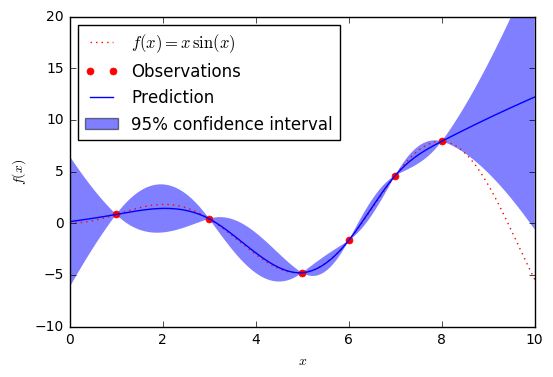

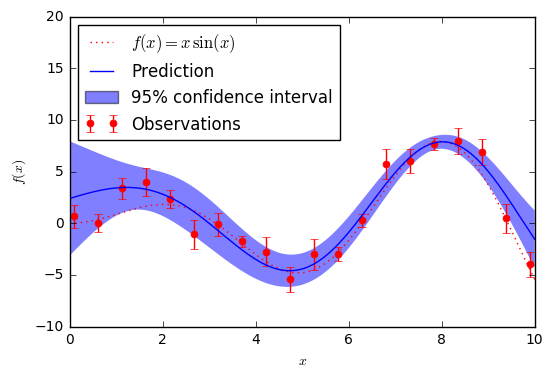

In [9]:
#import sklearn
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcess
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from matplotlib import pyplot as pl

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.plot(X, y, 'r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

#----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=(dy / y) ** 2,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

pl.show()

In [10]:
stds = [std(ips,axis=0) for ips in [psI1k_flat, pdf1dN1k_flat]]
print array(stds[0]).shape, array(stds[1]).shape

(101, 100) (101, 119)


In [11]:
def buildGPemulator(x,y,regr='linear', corr='cubic'):
    #gps = [GaussianProcess(regr='linear', corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
    #                     random_start=100, nugget=(dy[i]/y[i]) ** 2) for i in y.shape[-1]]
    #[gp.fit(x,y) for gp in gps]
    gp = GaussianProcess(regr=regr, corr=corr, theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                         random_start=100)
    gp.fit(x,y)
    out = lambda x: (gp.predict(x)).flatten() 
    return out

In [12]:
x,y,dy=params[2:],stats[0][2:],stds[0][2:]
print x.shape, y.shape, ((dy/y) ** 2).shape
test = buildGPemulator(x,y)

(99, 3) (99, 100) (99, 100)


In [14]:
edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])
ell_arr = range(100)#edge2center( linspace(100,5000,21))

In [15]:
idxnear = where(  (params.T[0]>0.05) & (params.T[0]<0.3)
                & (params.T[1]>0.29) & (params.T[1]<0.31)
                & (params.T[2]>1.9) & (params.T[2]<2.3))[0]

j=1
istd=std([psN_cov,pdf1dN_cov,pdf2dN_cov][j],axis=0)*sqrt(12.25/1e4)
corr_arr = ['squared_exponential','absolute_exponential','cubic','linear']#'generalized_exponential',

for i in idxnear:
    seed(45)
    x,y = delete(params,(0,i),axis=0),delete(stats[j],(0,i),axis=0)
    ell_arr = arange(len(istd))
    
    test_rbf =  WLanalysis.buildInterpolator(y, x)
    ps_RBF = test_rbf (params[i])    

    f, (ax,ax2) = subplots(2,1,figsize=(8,4))
    ax.plot(ell_arr, stats[j][i],'k-',label='true')
    ax.plot(ell_arr, ps_RBF,'r:',label='RBF')
    
    ax.set_yscale('log')
    ax2.plot(ell_arr, (ps_RBF-stats[j][i])/istd,'r:')
    
    ax2.plot(ell_arr, zeros(len(ell_arr)),'k-')

    for icorr in corr_arr:#['squared_exponential',]:
        #print icorr
        icolor=rand(3)
        test_gp = WLanalysis.buildInterpolator(y,x,function='GP',corr=icorr)
        ps_GP = test_gp(params[i])
        ax.plot(ell_arr, ps_GP,'--',color=icolor,label='GP(%s)'%(icorr))
        ax2.plot(ell_arr, (ps_GP-stats[j][i])/istd,'-',color=icolor)
        
    ax2.set_ylim(-1,1)
    ax.legend(loc='best',fontsize=8,frameon=0)
    ax2.set_xlabel('bin niumber')
    ax.set_ylabel('X')
    ax2.set_ylabel('deltaX/sigmaX')
    ax.set_title('Fig.4(6/25) test GP (PS) %s'%(params[i]),fontsize=10)
    #show()
    plt.tight_layout()
    savefig('plots/testGP_%s_%i.jpg'%(['ps','pdf1d','pdf2d'][j],i))
    close()

In [ ]:
print stats[0][1].shape, ps_RBF.shape, ps_GP.shape, len(istd)

In [ ]:
pdf2dN_cov.shape, ell_arr.shape

In [ ]:
stats[j][i].shape